In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos, exp
from numpy.linalg import inv
np.random.seed(3011)

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

In [16]:
t0 = 0
t1 = 10
#Algorithm: change beta here
def find_approximation(system: callable, t0: float, t1: float,
                       N=100, D_r=100, w=0.005, b=4, beta=1000):
    U: np.ndarray = system(np.linspace(t0, t1, N+1))
    D = U.shape[0]
    U_o = U[:, 1:]
    U_i = U[:, :-1]
    W_in = np.random.uniform(-w, w, (D_r, D))
    b_in = np.random.uniform(-b, b, (D_r,1))
    Phi = np.tanh(W_in @ U_i + b_in)
    W_LR = (U_o @ Phi.T @ inv(Phi @ Phi.T + beta * np.identity(D_r)))

    U_hat = np.atleast_2d(U[:, 0]).T
    for _ in range(N):
        u_n = U_hat[:, -1]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_hat = np.concatenate((U_hat, u_np1), axis=1)
        
    U_pred = np.atleast_2d(U_hat[:, -1]).T
    for _ in range(N):
        u_n = U_pred[:, -1]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_pred = np.concatenate((U_pred, u_np1), axis=1)
    #return U, U_hat
    return U, U_hat, U_pred

def find_norm2(system:callable, N_0, D_r0, beta = 0.01):
    U, U_hat, U_pred = find_approximation(system, t0, t1, N=N_0, D_r=D_r0, beta = beta) 
    norm2 = 0
    for n in range(N_0):
        norm2 += (np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))**2
    return np.sqrt(norm2) / N_0

In [17]:
#Lorenz system
def get_lorenz_vals(dt):
    def lorenz1(xyz, t, s=10, r=28, b=8/3):
        x,y,z = xyz
        dx = s*(y - x)
        dy = r*x - y - x*z
        dz = x*y - b*z
        return np.array([dx,dy,dz])
    
    from scipy.integrate import odeint
    sol = odeint(lorenz1, [0,2,0], dt)
    xs,ys,zs = sol.T

    return sol.T

-1.3075118069790195


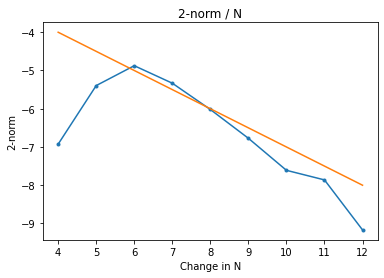

In [18]:
#plot for 2-norm
N = np.arange(4,13,1)

norm2 = []
for n in N:
    norm2.append(np.log2(find_norm2(get_lorenz_vals, 2**n, 2**n)))


#i2 = np.argmin(norm2)

plt.plot(N, norm2, marker=".")
plt.plot(N, -N/2-2)
#plt.plot(N[i2], norm2[i2], marker='o', label='minimum')
#plt.legend()
plt.xlabel("Change in N")
plt.ylabel("2-norm")
plt.title("2-norm / N")
print((norm2[-1]-norm2[-2])/(N[-1]-N[-2])) # the slope of the last two points

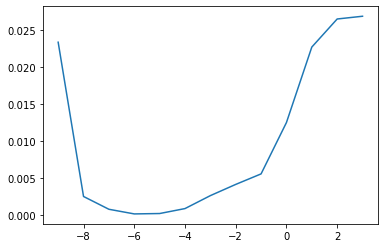

In [21]:
β=np.array([1000,100,10,1,0.1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9])
logβ = np.log10(β)

norm2 = []
for b in β:
    norm2.append(find_norm2(get_lorenz_vals, 2000, 300, beta=b))

plt.plot(logβ,norm2)
# 2-norm and logβ